## Notebook for Modeling
* trying a variety of values and inputs, to see what creates the best results

In [66]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [41]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [168]:
train_size = 5216 
val_size = 624

val_gen = ImageDataGenerator().flow_from_directory('data/test', target_size=(64, 64), 
                                                   batch_size=val_size, color_mode='grayscale')
val_img,val_labels = next(val_gen)

train_gen = ImageDataGenerator().flow_from_directory('data/train', target_size=(64, 64), 
                                                   batch_size=train_size, color_mode='grayscale')
train_orig_img,train_orig_labels = next(train_gen)


random_gen = ImageDataGenerator( rotation_range = 10,width_shift_range = 0.1,height_shift_range = 0.15,
                                shear_range = 0.3,zoom_range = 0.2,channel_shift_range=50,
                                fill_mode = 'nearest').flow(train_img,train_labels,batch_size=train_size)
random1_img,random1_labels = next(random_gen)
random2_img,random2_labels = next(random_gen)
train_img = np.concatenate((train_orig_img,random1_img,random2_img))
train_labels = np.concatenate((train_orig_labels,random1_labels,random2_labels))

train_unrow = train_img.reshape(train_size*3,-1)/255
val_unrow = val_img.reshape(val_size,-1)/255
train_orig_unrow = train_orig_img.reshape(train_size,-1)/255

train_y = train_labels[:,1].T
val_y = val_labels[:,1].T
train_orig_y = train_orig_labels[:,1].T

Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [138]:
train_img.shape

(15648, 64, 64, 1)

Activations to try: relu, tanh

In [10]:
relu_model = models.Sequential()
relu_model.add(layers.Dense(64,activation='relu',input_shape=(4096,)))
relu_model.add(layers.Dense(32,activation='relu'))
relu_model.add(layers.Dense(1,activation='sigmoid',input_shape=(4096,)))
relu_model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [15]:
results=relu_model.fit(train_unrow,train_y,epochs=100,batch_size=10,validation_data=(val_unrow,val_y),verbose=False)

In [16]:
results_train = relu_model.evaluate(train_unrow,train_y)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = relu_model.evaluate(val_unrow,val_y)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

500/500 [==============================] - 0s 58us/step
----------
Training Loss: 0.00139 
Training Accuracy: 1.0
50/50 [==============================] - 0s 160us/step
----------
Validation Loss: 0.953 
Validation Accuracy: 0.8


15648/15648 [==============================] - 1s 48us/step
----------
Training Loss: 0.907 
Training Accuracy: 0.257
624/624 [==============================] - 0s 53us/step
----------
Validation Loss: 0.836 
Validation Accuracy: 0.375


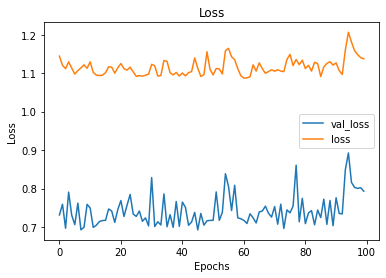

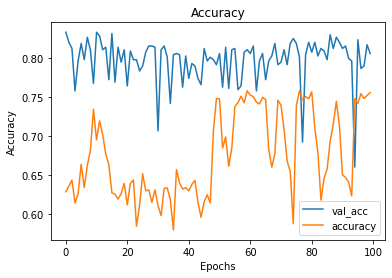

In [158]:
tanh_model = models.Sequential()
tanh_model.add(layers.Dense(64,activation='tanh',input_shape=(4096,)))
tanh_model.add(layers.Dense(32,activation='tanh'))
tanh_model.add(layers.Dense(1,activation='sigmoid'))
tanh_model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])

cl_weights = cl_weights = {0:3,1:1}
results=relu_model.fit(train_unrow,train_y,epochs=100,batch_size=1000,validation_data=(val_unrow,val_y),
                       verbose=False,class_weight=cl_weights)

results_train = tanh_model.evaluate(train_unrow,train_y)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = tanh_model.evaluate(val_unrow,val_y)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)

Relu *significantly* better than tanh. Next: try a variety of hidden nodes, epochs, batch_size, optimizers

15648/15648 [==============================] - 1s 35us/step
----------
Training Loss: 0.477 
Training Accuracy: 0.839
624/624 [==============================] - 0s 42us/step
----------
Validation Loss: 0.445 
Validation Accuracy: 0.827


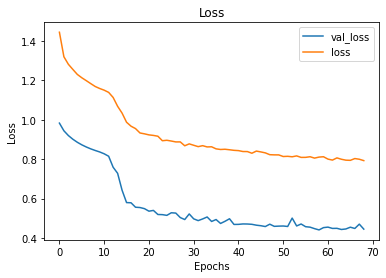

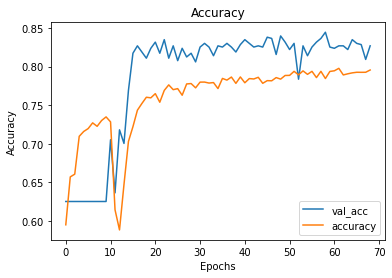

In [176]:
# Best model

relu_model = models.Sequential()
relu_model.add(layers.Dropout(0.3,input_shape=(4096,)))
relu_model.add(layers.Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
relu_model.add(layers.Dropout(0.3))
relu_model.add(layers.Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
relu_model.add(layers.Dense(1,activation='sigmoid'))
relu_model.compile(loss='binary_crossentropy',optimizer='Adamax',metrics=['accuracy'])

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
cl_weights = {0:3,1:1}

results=relu_model.fit(train_unrow,train_y,epochs=100,batch_size=1000,validation_data=(val_unrow,val_y),
                       callbacks=early_stopping,verbose=False,class_weight=cl_weights)

results_train = relu_model.evaluate(train_unrow,train_y)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = relu_model.evaluate(val_unrow,val_y)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)

15648/15648 [==============================] - 0s 32us/step
----------
Training Loss: 0.737 
Training Accuracy: 0.828
624/624 [==============================] - 0s 51us/step
----------
Validation Loss: 0.745 
Validation Accuracy: 0.825


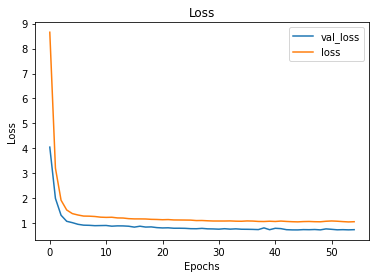

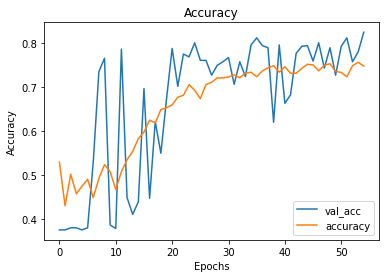

In [161]:
# Similar to best model, but with L1 regularization

relu_model = models.Sequential()
relu_model.add(layers.Dropout(0.3,input_shape=(4096,)))
relu_model.add(layers.Dense(32,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
relu_model.add(layers.Dropout(0.3))
relu_model.add(layers.Dense(8,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
relu_model.add(layers.Dense(1,activation='sigmoid'))
relu_model.compile(loss='binary_crossentropy',optimizer='Adamax',metrics=['accuracy'])

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
cl_weights = {0:3,1:1}

results=relu_model.fit(train_unrow,train_y,epochs=100,batch_size=1000,validation_data=(val_unrow,val_y),
                       callbacks=early_stopping,verbose=False,class_weight=cl_weights)

results_train = relu_model.evaluate(train_unrow,train_y)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = relu_model.evaluate(val_unrow,val_y)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)

5216/5216 [==============================] - 0s 32us/step
----------
Training Loss: 0.364 
Training Accuracy: 0.94
624/624 [==============================] - 0s 37us/step
----------
Validation Loss: 0.586 
Validation Accuracy: 0.801


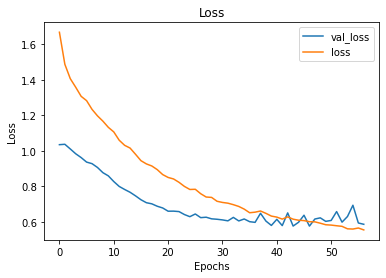

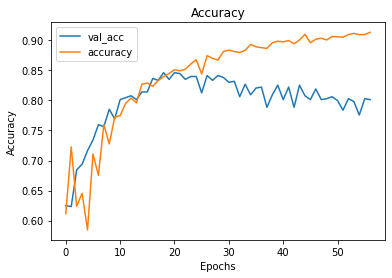

In [175]:
# Same parameters as best model, but with only original training images, no generated ones

relu_model = models.Sequential()
relu_model.add(layers.Dropout(0.3,input_shape=(4096,)))
relu_model.add(layers.Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
relu_model.add(layers.Dropout(0.3))
relu_model.add(layers.Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
relu_model.add(layers.Dense(1,activation='sigmoid'))
relu_model.compile(loss='binary_crossentropy',optimizer='Adamax',metrics=['accuracy'])

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
cl_weights = {0:3,1:1}

results=relu_model.fit(train_orig_unrow,train_orig_y,epochs=100,batch_size=1000,validation_data=(val_unrow,val_y),
                       callbacks=early_stopping,verbose=False,class_weight=cl_weights)

results_train = relu_model.evaluate(train_orig_unrow,train_orig_y)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = relu_model.evaluate(val_unrow,val_y)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)

15648/15648 [==============================] - 1s 34us/step
----------
Training Loss: 0.5 
Training Accuracy: 0.822
624/624 [==============================] - 0s 48us/step
----------
Validation Loss: 0.444 
Validation Accuracy: 0.835


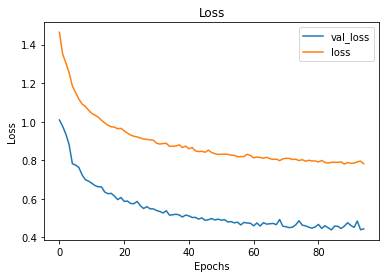

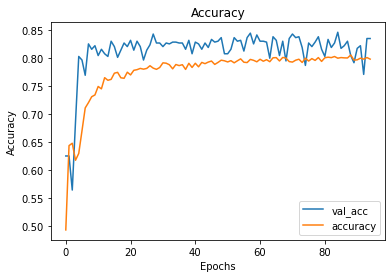

In [171]:
# rerun of best model, to confirm results were not a one time result

relu_model = models.Sequential()
relu_model.add(layers.Dropout(0.3,input_shape=(4096,)))
relu_model.add(layers.Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
relu_model.add(layers.Dropout(0.3))
relu_model.add(layers.Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
relu_model.add(layers.Dense(1,activation='sigmoid'))
relu_model.compile(loss='binary_crossentropy',optimizer='Adamax',metrics=['accuracy'])

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
cl_weights = {0:3,1:1}

results=relu_model.fit(train_unrow,train_y,epochs=100,batch_size=1000,validation_data=(val_unrow,val_y),
                       callbacks=early_stopping,verbose=False,class_weight=cl_weights)

results_train = relu_model.evaluate(train_unrow,train_y)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = relu_model.evaluate(val_unrow,val_y)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)

15648/15648 [==============================] - 0s 29us/step
----------
Training Loss: 0.766 
Training Accuracy: 0.707
624/624 [==============================] - 0s 36us/step
----------
Validation Loss: 0.685 
Validation Accuracy: 0.772


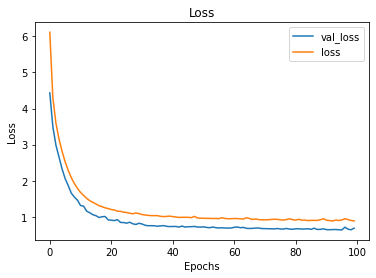

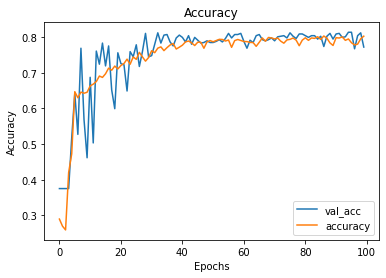

In [147]:
# L1 regularization, opt=Adamax, no Dropout

relu_model = models.Sequential()
relu_model.add(layers.Dense(16,activation='relu',input_shape=(4096,), kernel_regularizer=regularizers.l1(0.005)))
relu_model.add(layers.Dense(8,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
relu_model.add(layers.Dense(4,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
relu_model.add(layers.Dense(1,activation='sigmoid'))
relu_model.compile(loss='binary_crossentropy',optimizer='Adamax',metrics=['accuracy'])

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

cl_weights = {0:3,1:1}

results=relu_model.fit(train_unrow,train_y,epochs=100,batch_size=1000,validation_data=(val_unrow,val_y),
                       callbacks=early_stopping,verbose=False,class_weight=cl_weights)

results_train = relu_model.evaluate(train_unrow,train_y)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = relu_model.evaluate(val_unrow,val_y)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)

15648/15648 [==============================] - 0s 24us/step
----------
Training Loss: 0.589 
Training Accuracy: 0.743
624/624 [==============================] - 0s 30us/step
----------
Validation Loss: 0.665 
Validation Accuracy: 0.625


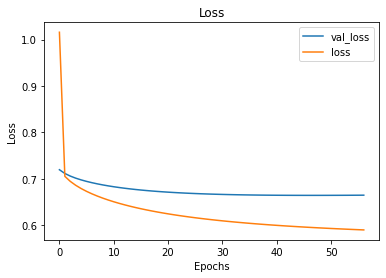

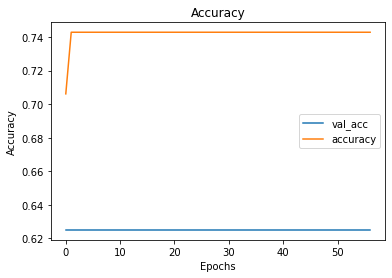

In [148]:
# Less complex model, with he initializer

relu_model = models.Sequential()
relu_model.add(layers.Dense(8,activation='relu',input_shape=(4096,),
                            kernel_regularizer=regularizers.l2(0.005),kernel_initializer='he_normal'))
relu_model.add(layers.Dense(1,activation='sigmoid'))
relu_model.compile(loss='binary_crossentropy',optimizer='Adagrad',metrics=['accuracy'])

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
results=relu_model.fit(train_unrow,train_y,epochs=100,batch_size=512,validation_data=(val_unrow,val_y),
                       callbacks=early_stopping,verbose=False)

results_train = relu_model.evaluate(train_unrow,train_y)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = relu_model.evaluate(val_unrow,val_y)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)

### Regularization:
* Dropout
* L1
* L2
* early_stopping

In [178]:
test_gen = ImageDataGenerator().flow_from_directory('data/val', target_size=(64, 64), 
                                                   batch_size=16, color_mode='grayscale')
test_img,test_labels = next(val_gen)

test_unrow = test_img.reshape(val_size,-1)/255

test_y = test_labels[:,1].T

Found 16 images belonging to 2 classes.


In [179]:
relu_model.evaluate(test_unrow,test_y)

624/624 [==============================] - 0s 66us/step


[0.44537702890542835, 0.8269230723381042]

In [177]:
import pickle
with open('model.pickle','wb') as f:
    pickle.dump(relu_model,f)